In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [4]:
# Showing one example
data_loader = loaders.DataLoader(data_source = "real", logger=logger)
df_table_origin = data_loader.load_annotations_df()

#k = 5
#data_loader.showing_example(k)
#data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [18]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

tqdm.pandas()

used_model = "clip"

if used_model == "clip":
    input_size = 512
elif used_model == "blip":
    input_size = 256


# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

category = "animal"
logger.info(f"Processing OOD Category: {category}")
ood_category = [category]
ind_category = [x for x in data_loader.supercategories if x not in ood_category]

df_table = df_table_origin.copy()
df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ood_category) else 1)
df_table['OOD'].value_counts()

if data_loader.data_source == "real":
    #dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_summary/mmd_summary_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features_single.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/qa_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

logger.info(f"Calculating Similarity Scores")

def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)

image_model_loader = model.model_loader(logger=logger,
                                input_size=input_size,
                                output_size=len(ind_category),
                                num_epochs=6,
                                learning_rate=0.001,
                                proportion = 0.8,
                                seed = 20)

dialogue_model_loader = model.model_loader(logger=logger,
                                input_size=input_size,
                                output_size=len(ind_category),
                                num_epochs=6,
                                learning_rate=0.001,
                                seed = 20)    

2024-08-04 17:34:28,693 - notebook_logger - INFO - Processing OOD Category: animal
2024-08-04 17:34:30,040 - notebook_logger - INFO - Calculating Similarity Scores
2024-08-04 17:34:30,267 - notebook_logger - INFO - Setting random seed: 20
2024-08-04 17:34:30,270 - notebook_logger - INFO - Setting random seed: 20


In [19]:
(
df_ind_train, 
df_test, 
X_train_image, 
X_test_image, 
X_train_dialogue, 
X_test_dialogue, 
Y_train, 
Y_test) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = True, mismatch_num = 3000)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test, ood_category = '_'.join(ood_category))
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test, ood_category = '_'.join(ood_category))


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]
2024-08-04 17:37:04,789 - notebook_logger - INFO - Model saved at f:\Github\multimodal_ood\models\DNN\models\DNN\image_model_animal_6_0.001.pth
100%|██████████| 6/6 [00:11<00:00,  1.85s/it]
2024-08-04 17:37:15,908 - notebook_logger - INFO - Model saved at f:\Github\multimodal_ood\models\DNN\models\DNN\image_model_animal_6_0.001.pth


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          2.,   0.,   1.,   1.,   2.,   1.,   2.,   1.,   1.,   2.,   3.,
          5.,   9.,   3.,  18.,  11.,   7.,  21.,  22.,  32.,  32.,  42.,
         43.,  47.,  64.,  60.,  67.,  99., 127., 109., 149., 171., 176.,
        188., 209., 246., 268., 275., 318., 341., 358., 413., 397., 389.,
        365., 392., 382., 369., 360., 345., 329., 268., 241., 246., 245.,
        206., 181., 164., 146., 130., 103.,  88.,  76.,  66.,  60.,  60.,
         38.,  34.,  22.,  28.,  25.,  15.,  13.,   9.,  11.,   6.,   3.,
          4.,   1.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.03881817, 0.04134365, 0.04386912, 0.0463946 , 0.04892007,
        0.05144555, 0.05397102, 0.0564965 , 0.05902197, 0.06154745,
        0.06407292, 0.0665984 , 0.06912387, 0.07164935, 0.07417482,
        0.0767003 , 0.07922577, 0.08175125, 0.08427672, 0.0868022 ,
        0.08932767, 0.09185315, 0.09437862, 0.

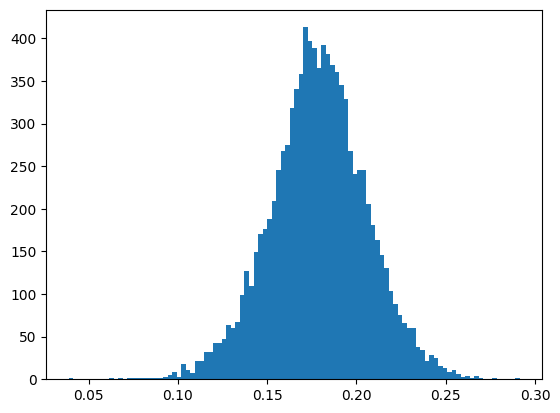

In [20]:
plt.hist(df_test['image_text_similarity'], bins=100)

In [21]:
score_type_list = ["prob", "energy", "logits", "msp", "odin", "mahalanobis"]
for score_type in score_type_list:
    if score_type != "mahalanobis":
        image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True)
        dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True)

    else:
        image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True,
                                                            X_train=X_train_image,
                                                            Y_train=Y_train)
        dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True,
                                                            X_train=X_train_dialogue,
                                                            Y_train=Y_train)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    if score_type in ["energy", "logits", "prob", "odin", "mahalanobis"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image'] + df_test[f'{score_type}_sum_dialogue']




2024-08-04 17:37:16,426 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:37:16,702 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:37:16,978 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:37:17,249 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:37:17,555 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:37:17,900 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:37:18,180 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:37:18,471 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:37:19,630 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:37:20,737 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:37:53,775 - notebook_logger - INFO - Test Loss: 0.2289, Test Accur

In [24]:
score_type_list = ["prob", "energy", "logits", "msp", "odin", "mahalanobis"]
alpha = 0.95
gamma = 0.5
for score_type in score_type_list:
    if score_type != "mahalanobis":
        image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True)
        dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True)

    else:
        image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True,
                                                            X_train=X_train_image,
                                                            Y_train=Y_train)
        dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True,
                                                            X_train=X_train_dialogue,
                                                            Y_train=Y_train)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    if score_type == "mahalanobis":
        df_test[f'{score_type}_max_image_tranform'] = 4 * (df_test['image_text_similarity'] ** (-1)) * df_test[f'{score_type}_max_image'] 
        df_test[f'{score_type}_max_dialogue_tranform'] = 4 * (df_test['image_text_similarity'] ** (-1)) * df_test[f'{score_type}_max_dialogue']
        df_test[f'{score_type}_sum_image_tranform'] = 4 * (df_test['image_text_similarity'] ** (-1))* df_test[f'{score_type}_sum_image']
        df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * (df_test['image_text_similarity'] ** (-1)) * df_test[f'{score_type}_sum_dialogue'] 
    else:
        df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
        df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
        df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
        df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']
    df_test[f'{score_type}_overall_simialrity_max'] = alpha * df_test[f'{score_type}_max_image'] + (1-alpha)*df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_overall_simialrity_max_transform'] =  alpha*df_test[f'{score_type}_max_image_tranform'] + (1-alpha)*df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits", "prob", "odin", "mahalanobis"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = alpha*df_test[f'{score_type}_sum_image'] + (1-alpha)*df_test[f'{score_type}_sum_dialogue']
        df_test[f'{score_type}_overall_simialrity_sum_transform'] = alpha*df_test[f'{score_type}_sum_image_tranform'] + (1-alpha)*df_test[f'{score_type}_sum_dialogue_tranform']


# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_sum_transform')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_max_transform')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max'),
        "Overall_Transform": eval_dict('msp_overall_simialrity_max_transform')
    },
    "Max Prob": {
        "Image": eval_dict('prob_max_image'),
        "Dialogue": eval_dict('prob_max_dialogue'),
        "Overall": eval_dict('prob_overall_simialrity_max'),
        "Overall_Transform": eval_dict('prob_overall_simialrity_max_transform')
    },
    "Sum Prob": {
        "Image": eval_dict('prob_sum_image'),
        "Dialogue": eval_dict('prob_sum_dialogue'),
        "Overall": eval_dict('prob_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('prob_overall_simialrity_sum_transform')
    },
    "Max Odin": {
        "Image": eval_dict('odin_max_image'),
        "Dialogue": eval_dict('odin_max_dialogue'),
        "Overall": eval_dict('odin_overall_simialrity_max'),
        "Overall_Transform": eval_dict('odin_overall_simialrity_max_transform')
    },
    "Sum Odin": {
        "Image": eval_dict('odin_sum_image'),
        "Dialogue": eval_dict('odin_sum_dialogue'),
        "Overall": eval_dict('odin_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('odin_overall_simialrity_sum_transform')
    },
    "Max Mahalanobis": {
        "Image": eval_dict('mahalanobis_max_image'),
        "Dialogue": eval_dict('mahalanobis_max_dialogue'),
        "Overall": eval_dict('mahalanobis_overall_simialrity_max'),
        "Overall_Transform": eval_dict('mahalanobis_overall_simialrity_max_transform')
    },
    "Sum Mahalanobis": {
        "Image": eval_dict('mahalanobis_sum_image'),
        "Dialogue": eval_dict('mahalanobis_sum_dialogue'),
        "Overall": eval_dict('mahalanobis_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('mahalanobis_overall_simialrity_sum_transform')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_max_transform')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_sum_transform')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result_df = result[['Image', 'Dialogue', 'Overall', 'Overall_Transform']]
result_df.reset_index(inplace=True)
order = ['Max Prob', 
         'Sum Prob', 
         'Max Logits', 
         'Sum Logits', 
         'Max Odin',
         'Sum Odin',
         'Max Mahalanobis',
         'Sum Mahalanobis',
         'MSP', 
         'Energy Sum', 
         'Energy Max']
result_df = result_df.set_index('Score').loc[order].reset_index()
def convert_to_percentage(lst):
    return ' / '.join(f'{x*100:.1f}' for x in lst)


result_df['Image'] = result_df['Image'].apply(convert_to_percentage)
result_df['Dialogue'] = result_df['Dialogue'].apply(convert_to_percentage)
result_df['Overall'] = result_df['Overall'].apply(convert_to_percentage)
result_df['Overall_Transform'] = result_df['Overall_Transform'].apply(convert_to_percentage)

latex_table = result_df.to_latex(index=False, column_format='|l|c|c|c|c|', header=["Score", "Image", "Dialogue", "Overall", "Overall_Transform"], escape=False)

print(latex_table)

2024-08-04 17:55:38,206 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:55:38,493 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:55:38,811 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:55:39,109 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:55:39,441 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:55:39,730 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:55:40,039 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:55:40,387 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
2024-08-04 17:55:41,639 - notebook_logger - INFO - Test Loss: 0.2289, Test Accuracy: 0.4339
2024-08-04 17:55:42,902 - notebook_logger - INFO - Test Loss: 0.4126, Test Accuracy: 0.0908
